In [1]:
import os
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
import cv2
from tensorflow import keras
import shutil
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import random
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU

In [9]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\test_mhd\sujetos"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\test_mhd\mascaras"
sujetos = os.listdir(fp1)
segmentaciones = os.listdir(fp2)

In [10]:
suj_train,suj_test,seg_train,seg_test = train_test_split(sujetos,segmentaciones,train_size=0.7,random_state=23)

In [11]:

fp1 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\test_mhd\sujetos"
fp0 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\test_mhd\mascaras"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\test_mhd\train_data\sujetos"
fp3 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\test_mhd\test_data\sujetos"
fp4 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\test_mhd\train_data\mascaras"
fp5 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\test_mhd\test_data\mascaras"
for file in suj_train:
    shutil.move(os.path.join(fp1,file), os.path.join(fp2,file))
for file in suj_test:
    shutil.move(os.path.join(fp1,file), os.path.join(fp3,file))
for file in seg_train:
    shutil.move(os.path.join(fp0,file), os.path.join(fp4,file))
for file in seg_test:
    shutil.move(os.path.join(fp0,file), os.path.join(fp5,file))

In [2]:
is_gpu_available = (len(tf.config.list_physical_devices('GPU')) > 0)
print(is_gpu_available)

True


--- UNET ---


In [3]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

In [4]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    #x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)
    x = Dropout(0.2)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    #x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

In [5]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [6]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [7]:
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
my_unet = build_unet(input_shape=(384,384,1), n_classes=1)
print(my_unet.summary())

In [9]:
my_unet.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2),"Accuracy"])

In [10]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\separadas2\train_data"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\ds_mezcla_segmentacion integra\separadas2\test_data"
sujetos = os.listdir(fp1)
segmentaciones = os.listdir(fp2)

In [114]:
sujetos = [os.path.join(fp1,suj) for suj in sujetos[400:900]]
images = [cv2.imread(img, 0) for img in sujetos]
sujeto_ds = np.array(images)
sujeto_ds = np.expand_dims(sujeto_ds, axis = 3)

In [115]:
mascaras = [os.path.join(fp2,mas) for mas in segmentaciones[400:900]]
images = [cv2.imread(img, 0) for img in mascaras]
seg_ds= np.array(images)
seg_ds = np.expand_dims(seg_ds, axis = 3) 

In [116]:
print("Image data shape is: ", sujeto_ds.shape)
print("Mask data shape is: ", seg_ds.shape)
print("Max pixel value in image is: ", sujeto_ds.max())
print("Labels in the mask are : ", np.unique(seg_ds))

Image data shape is:  (500, 384, 384, 1)
Mask data shape is:  (500, 384, 384, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [117]:
#Normalize images
image_dataset = sujeto_ds /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = seg_ds /255.  #PIxel values will be 0 or 1

In [27]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(fp1,batch_size=32,class_mode='binary',color_mode="grayscale",target_size=(384,384))
validation_generator = test_datagen.flow_from_directory(fp2,batch_size=32,class_mode='binary',color_mode="grayscale",target_size=(384,384))

Found 5440 images belonging to 2 classes.
Found 2334 images belonging to 2 classes.


In [17]:
datagen = ImageDataGenerator(rescale=1./255)


In [18]:

image_generator = datagen.flow_from_directory(os.path.join(fp1,"sujetos"),class_mode=None,color_mode="grayscale",target_size=(384,384),batch_size=4)

mask_generator = datagen.flow_from_directory(os.path.join(fp1,"mascaras"),class_mode=None,color_mode="grayscale",target_size=(384,384),batch_size=4)

train_generator = zip(image_generator, mask_generator)

Found 2720 images belonging to 1 classes.
Found 2720 images belonging to 1 classes.


In [199]:
train_generator

In [19]:
image_generator = datagen.flow_from_directory(os.path.join(fp2,"sujetos"),class_mode=None,color_mode="grayscale",target_size=(384,384),batch_size=4)

mask_generator = datagen.flow_from_directory(os.path.join(fp2,"mascaras"),class_mode=None,color_mode="grayscale",target_size=(384,384),batch_size=4)

validation_generator = zip(image_generator, mask_generator)

Found 1167 images belonging to 1 classes.
Found 1167 images belonging to 1 classes.


In [118]:

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

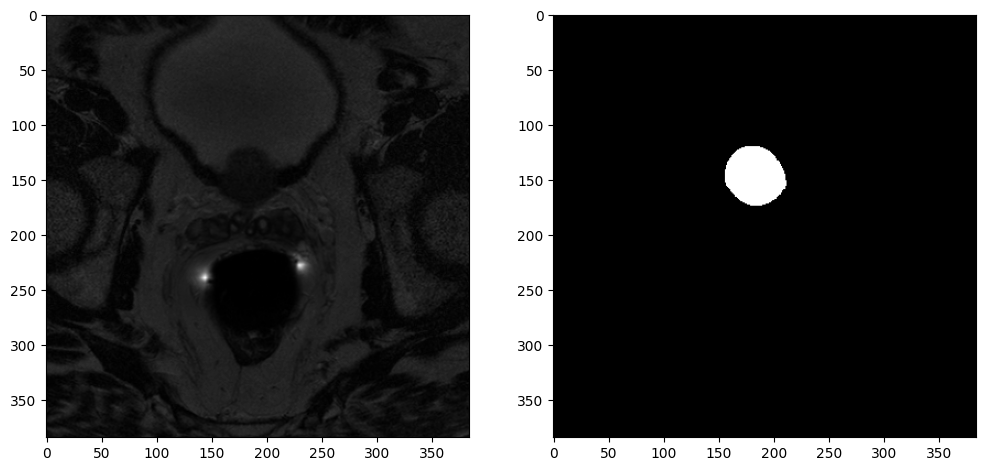

In [123]:
#Sanity check, view few mages


image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [14]:
keras.backend.clear_session()

In [20]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

In [22]:
history = my_unet.fit_generator(train_generator,
                    verbose=1, 
                    steps_per_epoch=150,
                    epochs=10,
                    validation_data=validation_generator, 
                    validation_steps=64,
                    callbacks=[early_stopping_cb])

Epoch 1/10


C:\Users\Pier\AppData\Local\Temp\ipykernel_1040\1856290294.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = my_unet.fit_generator(train_generator,


NotFoundError: Graph execution error:

Detected at node 'gradient_tape/U-Net/conv2d_17/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Pier\AppData\Local\Temp\ipykernel_1040\1650408944.py", line 1, in <module>
      history = my_unet.fit_generator(train_generator,
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 2507, in fit_generator
      return self.fit(
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/U-Net/conv2d_17/Conv2D/Conv2DBackpropInput'
Detected at node 'gradient_tape/U-Net/conv2d_17/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Pier\AppData\Local\Temp\ipykernel_1040\1650408944.py", line 1, in <module>
      history = my_unet.fit_generator(train_generator,
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 2507, in fit_generator
      return self.fit(
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/U-Net/conv2d_17/Conv2D/Conv2DBackpropInput'
2 root error(s) found.
  (0) NOT_FOUND:  No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 168806672 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 168806672 bytes.
  Profiling failure on CUDNN engine 3#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 39059456 bytes.
  Profiling failure on CUDNN engine 3: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 39059456 bytes.
  Profiling failure on CUDNN engine 4#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17187072 bytes.
  Profiling failure on CUDNN engine 4: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17187072 bytes.
  Profiling failure on CUDNN engine 5#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2735276032 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2735276032 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node gradient_tape/U-Net/conv2d_17/Conv2D/Conv2DBackpropInput}}]]
	 [[confusion_matrix/assert_less_1/Assert/AssertGuard/else/_29/confusion_matrix/assert_less_1/Assert/AssertGuard/Assert/data_0/_85]]
  (1) NOT_FOUND:  No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 168806672 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 168806672 bytes.
  Profiling failure on CUDNN engine 3#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 39059456 bytes.
  Profiling failure on CUDNN engine 3: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 39059456 bytes.
  Profiling failure on CUDNN engine 4#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17187072 bytes.
  Profiling failure on CUDNN engine 4: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17187072 bytes.
  Profiling failure on CUDNN engine 5#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2735276032 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2735276032 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node gradient_tape/U-Net/conv2d_17/Conv2D/Conv2DBackpropInput}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_3631]

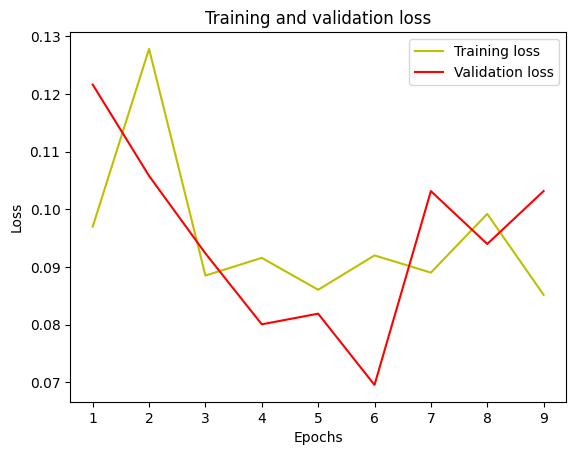

KeyError: 'accuracy'

In [67]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [126]:
predict = my_unet.predict_generator(validation_generator,300)

C:\Users\Pier\AppData\Local\Temp\ipykernel_1816\2685573797.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = my_unet.predict_generator(validation_generator,300)


ResourceExhaustedError: Graph execution error:

Detected at node 'U-Net/concatenate_3/concat' defined at (most recent call last):
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Pier\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Pier\AppData\Local\Temp\ipykernel_1816\2300658354.py", line 1, in <module>
      predict = my_unet.predict_generator(validation_generator,200)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 2582, in predict_generator
      return self.predict(
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\layers\merging\base_merge.py", line 196, in call
      return self._merge_function(inputs)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\layers\merging\concatenate.py", line 134, in _merge_function
      return backend.concatenate(inputs, axis=self.axis)
    File "c:\Users\Pier\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\backend.py", line 3572, in concatenate
      return tf.concat([to_dense(x) for x in tensors], axis)
Node: 'U-Net/concatenate_3/concat'
OOM when allocating tensor with shape[4,128,384,384] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node U-Net/concatenate_3/concat}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_12817]

In [127]:
predict.shape

(199, 384, 384, 1)

In [128]:
predict.max()

0.26818895

In [129]:
y_pred_thresholded = predict > 0.05

In [130]:
y_pred=my_unet.predict(X_test[0:5])
y_pred_thresholded = y_pred > 0.5


NameError: name 'X_test' is not defined

In [131]:
y_pred_thresholded[161,:,:,:].min()

True

In [132]:
a = predict[8,:,:,0]>0.2

In [133]:
a

array([[ True, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False,  True]])

In [120]:
a = np.array(a)

In [ ]:
a

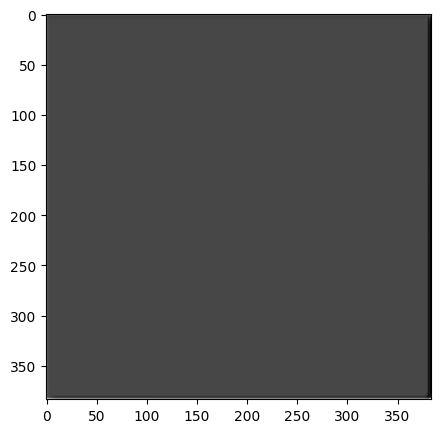

In [193]:
test_img_number = random.randint(0, predict.shape[0]-1)
plt.figure(figsize=(5, 5))
plt.imshow(predict[test_img_number,:,:,:],cmap="gray")


In [33]:

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, validation_generator)
print("Mean IoU =", IOU_keras.result().numpy())
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (my_unet.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.show()


ValueError: Attempt to convert a value (<zip object at 0x000001B451695040>) with an unsupported type (<class 'zip'>) to a Tensor.